In [1]:
!pip install pystan

In [3]:
!pip install --user fbprophet

In [4]:
!pip install pyramid


In [5]:
!pip install pyramid-arima


In [6]:
!pip install pmdarima

In [8]:
#!pip install pmdarima-arima

In [6]:
from fbprophet import Prophet
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import itertools
import scipy
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pyramid as pm
import pmdarima as pmd
from sklearn import metrics
from pmdarima.arima import auto_arima
from pyramid.arima import auto_arima
warnings.filterwarnings('ignore')

C:\Users\home pc\AppData\Roaming\Python\Python36\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [7]:
#PRINT MANY STATEMENTS AT SAME TIME USING THE BELOW COMMAND
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
fd = sns.load_dataset("flights")
fd.head()
fd.tail()
fd.shape
fd.describe()
fd.info()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


,year,month,passengers
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390
143,1960,December,432


(144, 3)

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
year          144 non-null int64
month         144 non-null category
passengers    144 non-null int64
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [9]:
fd_pivot = fd.pivot('month','year','passengers')
fd_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


<Figure size 1080x360 with 0 Axes>

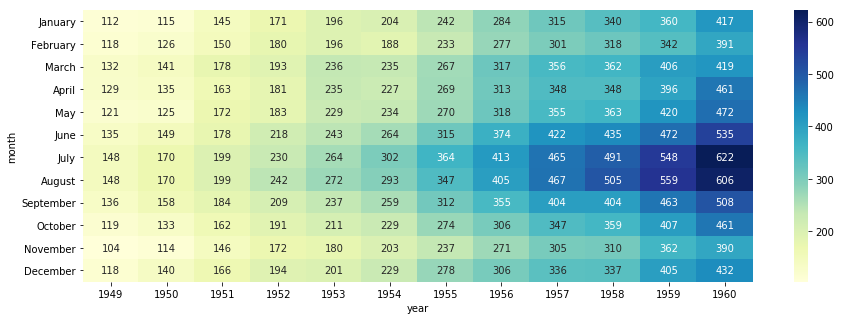

In [10]:
plt.figure(figsize=(15,5))
sns.heatmap(fd_pivot,annot= True, fmt = 'd', cmap='YlGnBu')
plt.show()

In [11]:
month = pd.date_range('19490131', periods=144, freq='M')
month

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [12]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
year          144 non-null int64
month         144 non-null category
passengers    144 non-null int64
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [13]:
fd['datestamp'] = month
fd.head()

,year,month,passengers,datestamp
0,1949,January,112,1949-01-31
1,1949,February,118,1949-02-28
2,1949,March,132,1949-03-31
3,1949,April,129,1949-04-30
4,1949,May,121,1949-05-31


In [14]:
data = fd.loc[:,('datestamp','passengers')]
data.head()
data.describe()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [15]:
data.set_index('datestamp',inplace= True)
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


<Figure size 1080x720 with 0 Axes>

Text(0.5,0,'Time')

Text(0,0.5,'Passengers in 1000')

Text(0.5,1,'# of Passengers over Time')

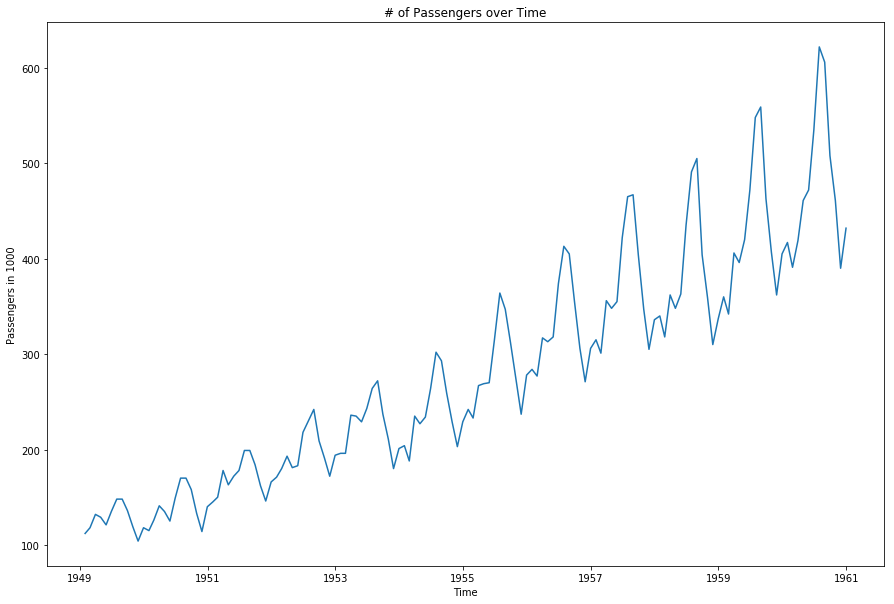

In [16]:
plt.figure(figsize=(15,10))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Passengers in 1000')
plt.title('# of Passengers over Time')
plt.show()

In [17]:
#Additive model
decomposition = seasonal_decompose(data,model = 'additive')

<Figure size 1440x720 with 0 Axes>

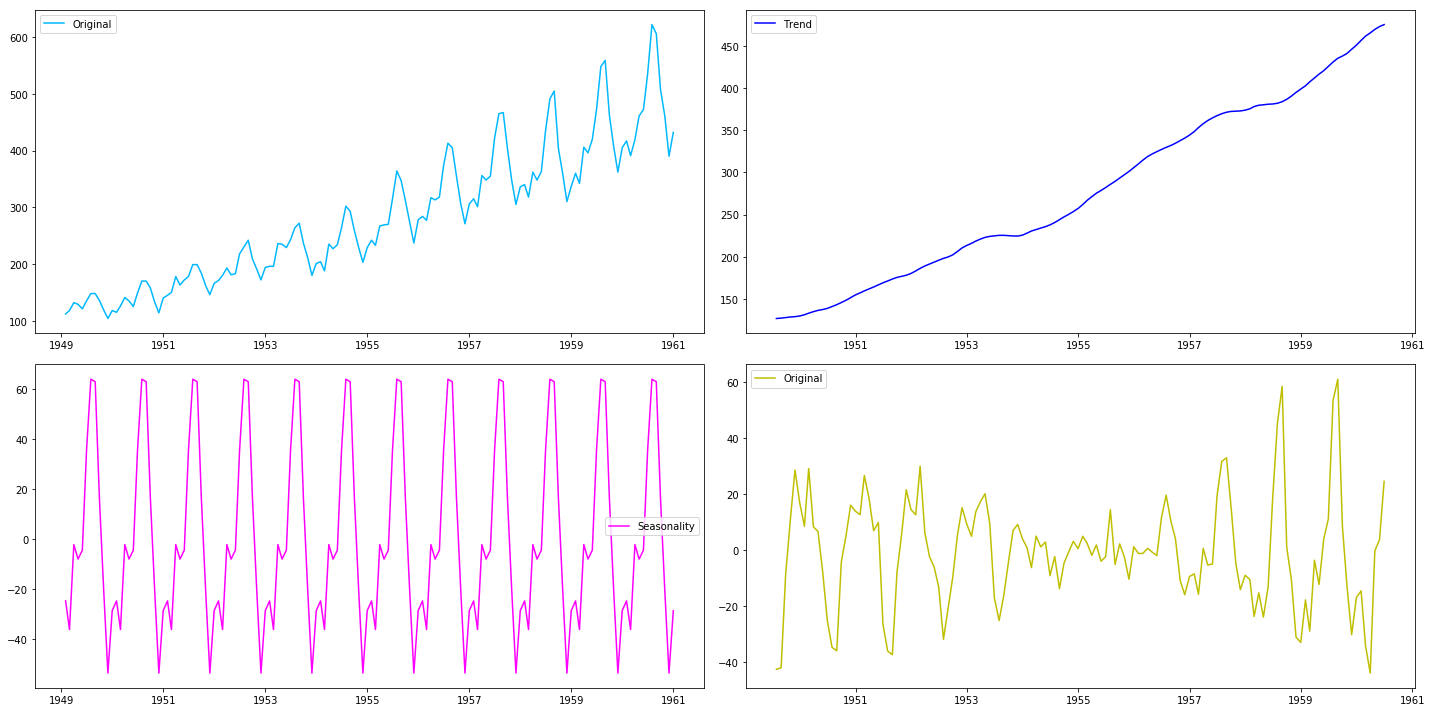

In [18]:
#plot trend of the series
plt.figure(figsize=(20,10))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(data,color = '#00b8ff',label='Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend, 'b', label='Trend')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(seasonal,color = '#ff00ff',label='Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(residual,'y',label='Original')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [19]:
#Multiplicative model
decomposition = seasonal_decompose(data,model = 'multiplicative')

<Figure size 1440x720 with 0 Axes>

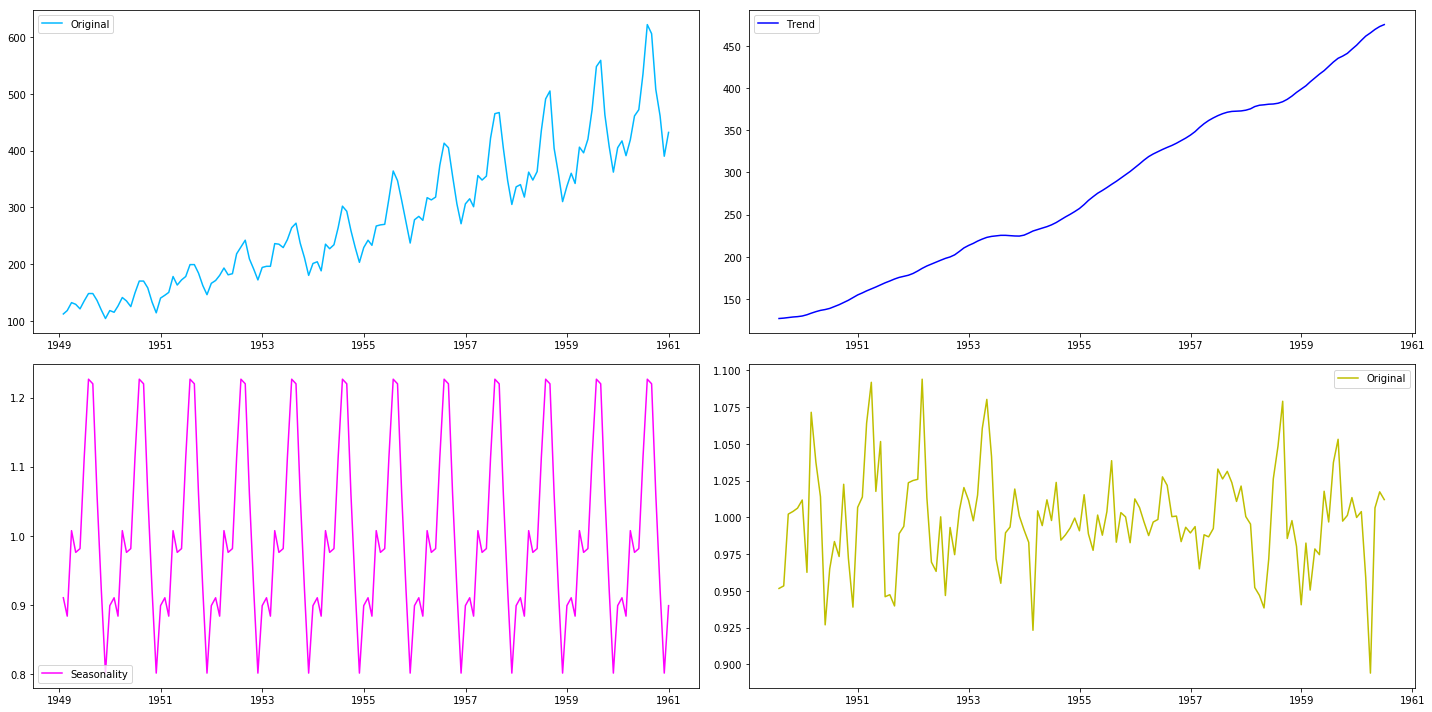

In [20]:
#plot trend of the series
plt.figure(figsize=(20,10))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(data,color = '#00b8ff',label='Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend, 'b', label='Trend')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(seasonal,color = '#ff00ff',label='Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(residual,'y',label='Original')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [21]:
#fd = fd.loc[:,['Passengers']]
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


In [22]:
data.reset_index(inplace=True)
data.head()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


In [23]:
data = data.rename(columns={"datestamp":"ds", "passengers":"y"})
data.head()

,ds,y
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


In [24]:
#Build the time series model using prophet package
my_forecast = Prophet(interval_width=0.95)

In [25]:
my_forecast.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
forecast_periods = my_forecast.make_future_dataframe(periods=36, include_history=True, freq='M')
forecast_periods

,ds
0,1949-01-31
1,1949-02-28
2,1949-03-31
3,1949-04-30
4,1949-05-31
5,1949-06-30
6,1949-07-31
7,1949-08-31
8,1949-09-30
9,1949-10-31


In [27]:
forecast = my_forecast.predict(forecast_periods)
forecast1 = forecast.loc[:,['ds','yhat']]
forecast1.head()

,ds,yhat
0,1949-01-31,84.486659
1,1949-02-28,77.027835
2,1949-03-31,110.637154
3,1949-04-30,108.057708
4,1949-05-31,111.461192


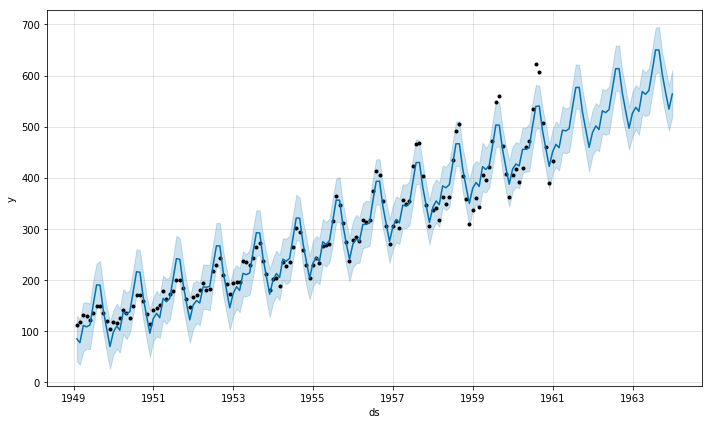

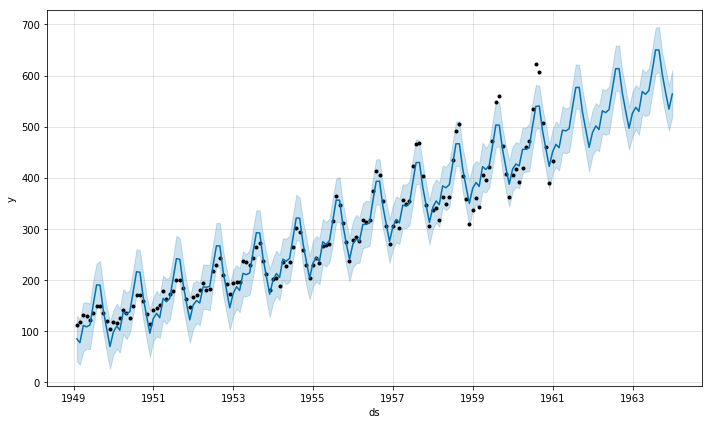

In [28]:
my_forecast.plot(forecast,uncertainty=True)


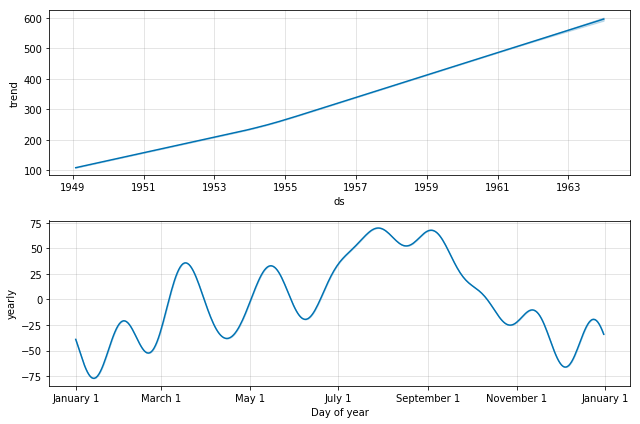

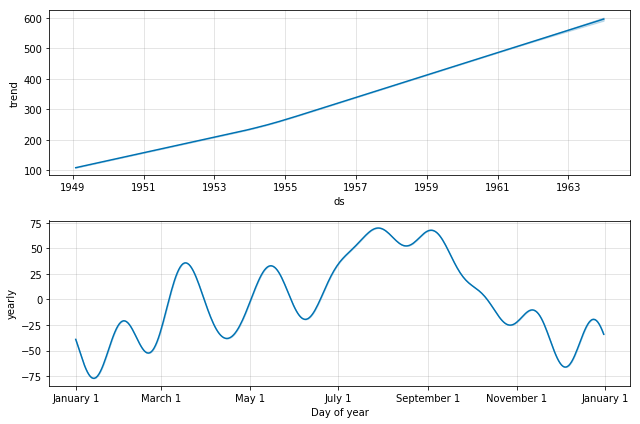

In [29]:
my_forecast.plot_components(forecast)



In [30]:
final_df = pd.merge(forecast1, data, on = 'ds', how = 'inner')
final_df.head()

,ds,yhat,y
0,1949-01-31,84.486659,112
1,1949-02-28,77.027835,118
2,1949-03-31,110.637154,132
3,1949-04-30,108.057708,129
4,1949-05-31,111.461192,121


In [31]:
#Compute Accuracy of the forecast


In [32]:
from sklearn import metrics
np.round(metrics.mean_absolute_error(final_df.yhat, final_df.y),0)

17.0

you can see from the above that on average we are off from the actual numbers by around 17. Let's see if we can improve this by taking log transformation of the 'y

In [33]:
data.head()

,ds,y
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


In [34]:
data.y = np.log(data.y)
data.head(5)

,ds,y
0,1949-01-31,4.718499
1,1949-02-28,4.770685
2,1949-03-31,4.882802
3,1949-04-30,4.859812
4,1949-05-31,4.795791


In [35]:
#build time series model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,1949-01-31
1,1949-02-28
2,1949-03-31
3,1949-04-30
4,1949-05-31
5,1949-06-30
6,1949-07-31
7,1949-08-31
8,1949-09-30
9,1949-10-31


,ds,yhat
0,1949-01-31,4.711608
1,1949-02-28,4.710102
2,1949-03-31,4.835053
3,1949-04-30,4.816537
4,1949-05-31,4.815471


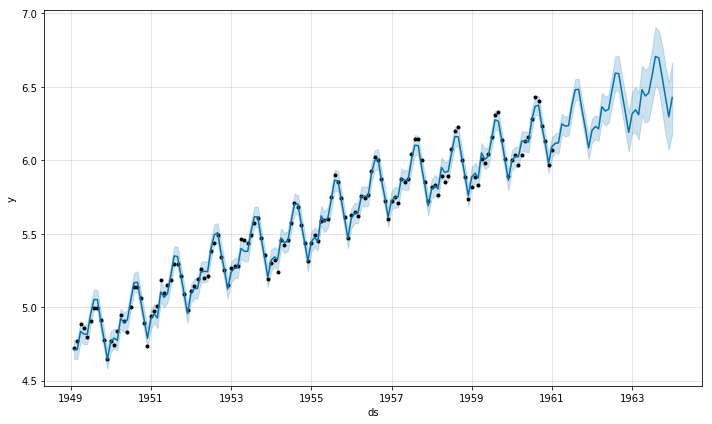

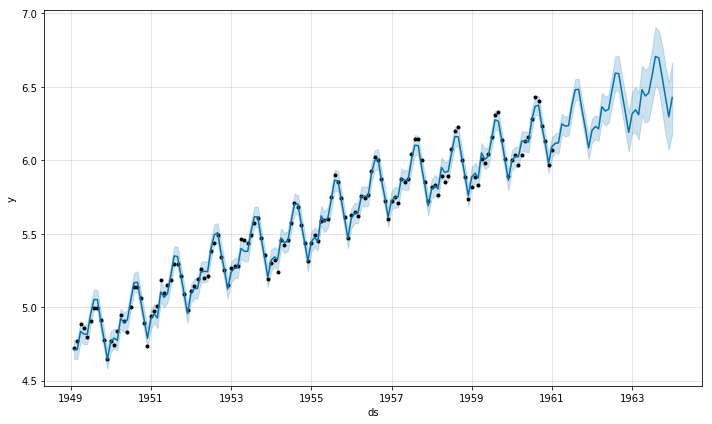

In [36]:
my_forecast = Prophet(interval_width=0.95)
my_forecast.fit(data)
forecast_periods = my_forecast.make_future_dataframe(periods=36, include_history=True, freq='M')
forecast_periods 
forecast = my_forecast.predict(forecast_periods)
forecast1 = forecast.loc[:,['ds','yhat']]
forecast1.head()
my_forecast.plot(forecast,uncertainty=True)


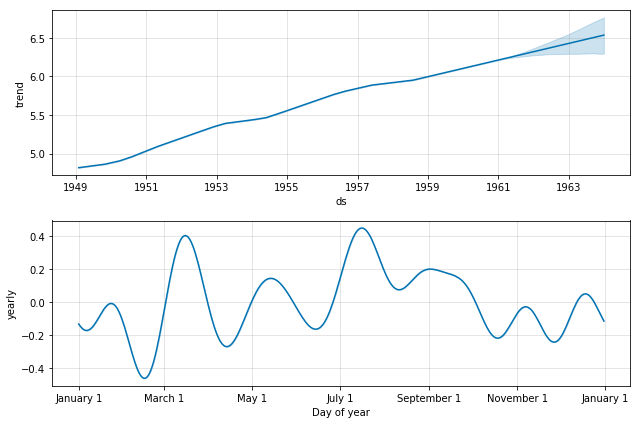

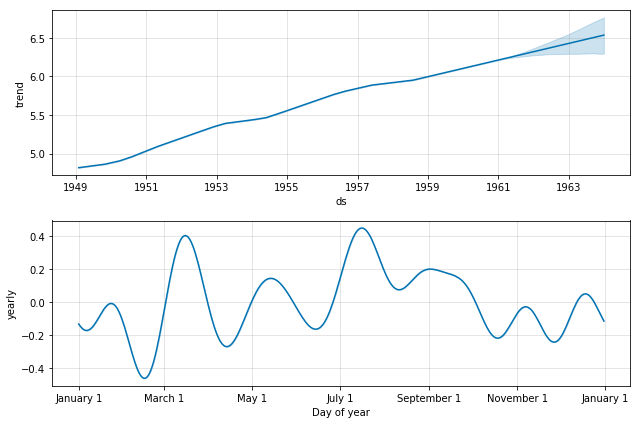

In [37]:
my_forecast.plot_components(forecast)



In [38]:
final_df1 = pd.merge(forecast1, data, on = 'ds', how = 'inner')
final_df1.head()

,ds,yhat,y
0,1949-01-31,4.711608,4.718499
1,1949-02-28,4.710102,4.770685
2,1949-03-31,4.835053,4.882802
3,1949-04-30,4.816537,4.859812
4,1949-05-31,4.815471,4.795791


In [39]:
#convert 'y' back to original scale

In [40]:
final_df1.yhat = np.e**(final_df1.yhat)
final_df1.y = np.e**(final_df1.y)
final_df1.head()

,ds,yhat,y
0,1949-01-31,111.230877,112.0
1,1949-02-28,111.063530,118.0
2,1949-03-31,125.845297,132.0
3,1949-04-30,123.536578,129.0
4,1949-05-31,123.404904,121.0


# compute Accuracy of the Forecast

In [41]:
np.round(metrics.mean_absolute_error(final_df1.yhat, final_df1.y),0)

7.0

you can see the converting the variable to log scale to make varaince more stable in the original data helped significantly in improving the forecast accuracy

In [42]:
final_df1.head()

,ds,yhat,y
0,1949-01-31,111.230877,112.0
1,1949-02-28,111.063530,118.0
2,1949-03-31,125.845297,132.0
3,1949-04-30,123.536578,129.0
4,1949-05-31,123.404904,121.0


In [43]:
final_df1.tail()

,ds,yhat,y
139,1960-08-31,587.381143,606.0
140,1960-09-30,509.617791,508.0
141,1960-10-31,453.021391,461.0
142,1960-11-30,395.312630,390.0
143,1960-12-31,442.748617,432.0


In [44]:
#Generate forecast values for the next 36 months along with the 95% confidance interval

In [45]:
forecast2 = forecast.loc[144:,['ds','yhat','yhat_lower','yhat_upper']]
forecast2.yhat = np.e**(forecast2.yhat)
forecast2.yhat_lower = np.e**(forecast2.yhat_lower)
forecast2.yhat_upper = np.e**(forecast2.yhat_upper)
np.round(forecast2,0)

,ds,yhat,yhat_lower,yhat_upper
144,1961-01-31,453.0,426.0,485.0
145,1961-02-28,454.0,422.0,487.0
146,1961-03-31,517.0,482.0,554.0
147,1961-04-30,509.0,474.0,542.0
148,1961-05-31,511.0,478.0,548.0
149,1961-06-30,586.0,544.0,627.0
150,1961-07-31,652.0,607.0,701.0
151,1961-08-31,654.0,607.0,703.0
152,1961-09-30,570.0,532.0,613.0
153,1961-10-31,503.0,467.0,544.0


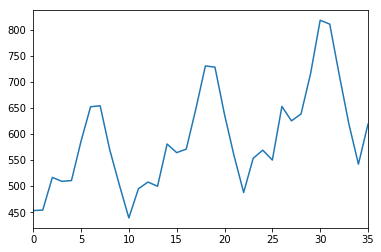

In [46]:
sns.tsplot(forecast2.yhat)
plt.show()